## HIV Zimbabwe

In [1]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import arviz as az
import dill

# JAX
import jax
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

#plt.style.use('bmh')

(63, 31)


<AxesSubplot:>

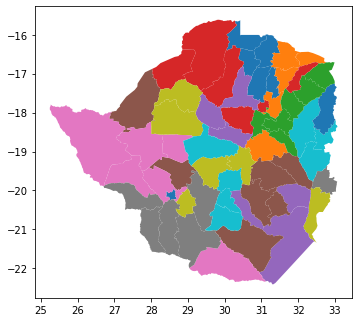

In [2]:
s = gpd.read_file("data/zwe2016phia.geojson")
print(s.shape)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s.plot(column='area_id', ax=ax, legend=False)

In [3]:
s.columns

Index(['indicator', 'survey_id', 'survey_mid_calendar_quarter', 'area_id',
       'area_name', 'res_type', 'sex', 'age_group', 'n_clusters',
       'n_observations', 'n_eff_kish', 'estimate', 'std_error', 'ci_lower',
       'ci_upper', 'y', 'n_obs', 'iso3', 'area_level', 'parent_area_id',
       'spectrum_region_code', 'area_sort_order', 'center_x', 'center_y',
       'area_level_label', 'display', 'spectrum_level', 'epp_level',
       'naomi_level', 'pepfar_psnu_level', 'geometry'],
      dtype='object')

/opt/anaconda3/envs/statrethinking/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0
(63, 5)


<AxesSubplot:>

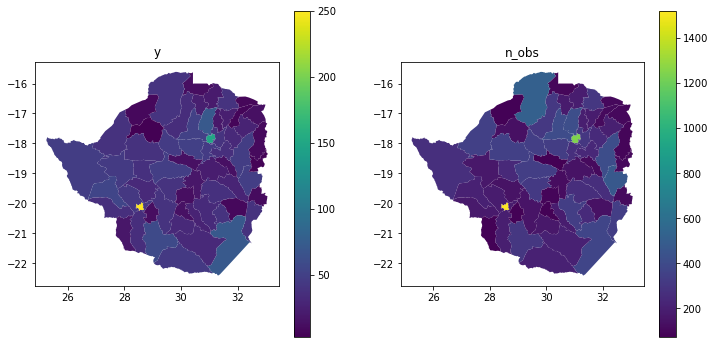

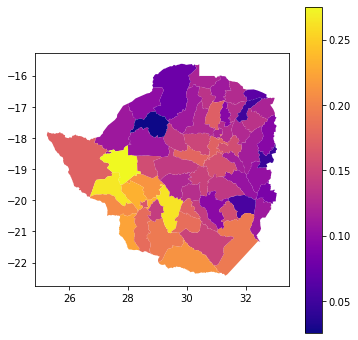

In [4]:
s = s[['area_id', 'geometry', 'y', 'n_obs', 'estimate']]
s['y'] = round(s['y']).astype(int)
s['n_obs'] = round(s['n_obs']).astype(int)
print(np.sum(np.isnan(s['n_obs'])))
print(s.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="y", ax=ax[0], legend=True)
s.plot(column="n_obs", ax=ax[1], legend=True)
ax[0].set_title( 'y')
ax[1].set_title( 'n_obs')


fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s.plot(column='estimate', ax=ax, legend=True, cmap='plasma')

In [5]:
s.head(3)

,area_id,geometry,y,n_obs,estimate
0,ZWE_2_1,"MULTIPOLYGON (((28.60837 -20.23077, 28.60534 -...",250,1520,0.164841
1,ZWE_2_2,"MULTIPOLYGON (((30.99973 -17.99862, 31.00954 -...",44,280,0.155943
2,ZWE_2_3,"MULTIPOLYGON (((31.13664 -17.92887, 31.13584 -...",148,1243,0.119002


# Prevalence model - CAR

## Compute adjacency matrix

In [6]:
# compute adjacency matrix
df1 = s['geometry']
line_gdf = df1.iloc[0:df1.shape[0]]
A = line_gdf.geometry.apply(lambda g: line_gdf.intersects(g))  
A = A * 1
A = np.array(A)
A = A - np.eye(A.shape[0])

# number of neighbours
d = A.sum(axis=0)

In [7]:
args = {
    'n_obs': jnp.array(s.n_obs),
    'A': A,
    'd': d
}

In [8]:
def model_CAR(args, y=None):
    
    n_obs = args['n_obs']
    A = args['A']
    d = args['d']
    
    N = len(n_obs)
    D = jnp.diag(d)
    
    # fixed effects
    alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))
    
    Q_std = D - alpha*A
    car_std = numpyro.sample('car_std', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q_std))


In [9]:
def prev_model_CAR(args, y=None):
    
    n_obs = args['n_obs']
    A = args['A']
    d = args['d']
    
    N = len(n_obs)
    D = jnp.diag(d)
    
    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Gamma(6, 4)) 
    alpha = numpyro.sample('alpha', dist.Uniform(low=0., high=1.))
    
    Q_std = D - alpha*A
    car_std = numpyro.sample('car_std', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q_std))
    sigma = numpyro.deterministic('sigma', 1./jnp.sqrt(tau))
    car = numpyro.deterministic('car', sigma * car_std)
    
    car0 = numpyro.deterministic('CAR 1', car[0])
    
    lp = b0 + car
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
     
    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [10]:
rng_key, rng_key_predict = random.split(random.PRNGKey(3))

# inference
start = time.time()
kernel = NUTS(prev_model_CAR)
mcmc_car = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc_car.run(rng_key, args, y = jnp.array(s.y))
t_elapsed = time.time() - start

prev_samples_car = mcmc_car.get_samples()
#mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████████████████████████████████████████| 3000/3000 [00:12<00:00, 230.80it/s, 31 steps of size 1.46e-01. acc. prob=0.93]


In [11]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_car.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 16 s
Average ESS for all CAR effects : 120


Text(0.5, 1.0, 'Estimated prevalence (CAR model)')

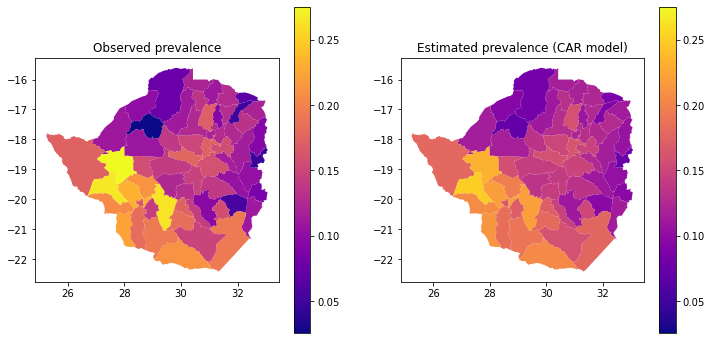

In [12]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_CAR, prev_samples_car)(random.PRNGKey(1), args)

theta_samps_car = prev_posterior_predictive['theta']
theta_mean_car = theta_samps_car.mean(axis=0)
bci_car_25 = np.quantile(theta_samps_car, 0.25, axis=0)
bci_car_75 = np.quantile(theta_samps_car, 0.75, axis=0)

s['theta_car'] = theta_mean_car

theta_observed = s['estimate']
theta_estimated_car = s['theta_car']

_max = np.max([theta_observed, theta_estimated_car])
_min = np.min([theta_observed, theta_estimated_car])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (CAR model)')

Text(0, 0.5, 'CAR estimated theta')

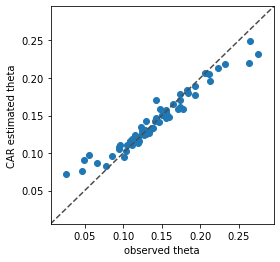

In [13]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(theta_observed, theta_estimated_car)
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("observed theta")
plt.ylabel("CAR estimated theta")

# Train VAE

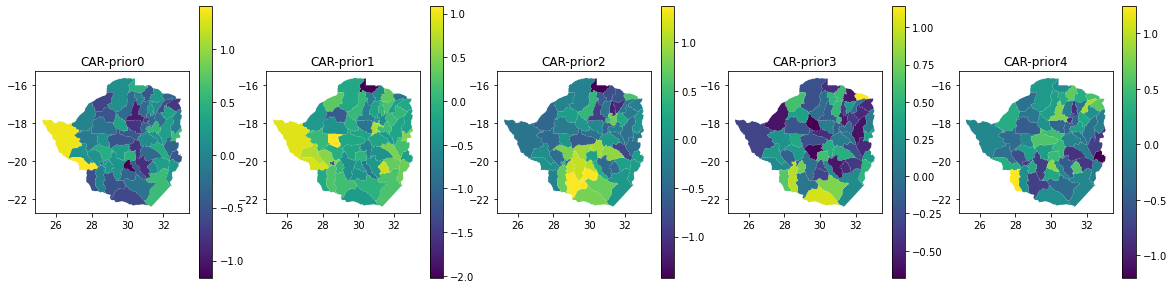

In [14]:
# CAR: prior predictive

rng_key, rng_key_ = random.split(random.PRNGKey(4))
car_predictive = Predictive(model_CAR, num_samples=5)
car_preds = car_predictive(rng_key_, args)
car_draws = car_preds['car_std']

s_plot = s.copy()
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'car_draw_' + str(i)
    s_plot[nm] = car_draws[i,:]
    s_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'CAR-prior' + str(i))

In [15]:
args = { # data
        'n_obs': jnp.array(s.n_obs),
        'A': A,
        'd': d,
    
        # VAE training
        "rng_key": random.PRNGKey(5),
        "num_epochs": 200, 
        "learning_rate": 1.0e-3, 
        "batch_size": 200, 
        "hidden_dim": 63,
        "z_dim": 50, 
        "num_train": 100,
        "num_test":100,
}

In [16]:
def vae_encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Elu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder( hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Elu,
        stax.Dense(out_dim, W_init=stax.randn())
    )

def vae_model(batch, hidden_dim, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder( hidden_dim, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((z_dim,)), jnp.ones((z_dim,))))
    gen_loc = decode(z)    
    numpyro.sample("obs", dist.Normal(gen_loc, .05), obs=batch) 
    #return 
    

def vae_guide(batch, hidden_dim,  z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

In [17]:
@jit
def epoch_train(rng_key, svi_state, num_train):

    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val # val -- svi_state
        batch = car_predictive(rng_key_i, args)['car_std']
        svi_state, loss = svi.update(svi_state, batch) 
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state)) #fori_loop(lower, upper, body_fun, init_val)

@jit
def eval_test(rng_key, svi_state, num_test):

    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = car_predictive(rng_key_i, args)['car_std']
        loss = svi.evaluate(svi_state, batch) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

In [18]:
adam = optim.Adam(step_size=args["learning_rate"])

#svi = SVI(vae_model, vae_guide, adam, RenyiELBO(alpha=-1, num_particles=4), 
svi = SVI(vae_model, vae_guide, adam, RenyiELBO(), 
          hidden_dim=args["hidden_dim"], 
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = car_predictive(rng_key_, args)['car_std']
svi_state = svi.init(rng_key_init, init_batch)

In [19]:
test_loss_list = []

for i in range(args['num_epochs']):
    
    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
    
    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print("Epoch {}: loss = {} ({:.2f} s.)".format(i, test_loss, time.time() - t_start))
    
    if math.isnan(test_loss): break

Epoch 0: loss = 58.35536575317383 (9.40 s.)
Epoch 1: loss = 51.31155014038086 (0.00 s.)
Epoch 2: loss = 47.395137786865234 (0.00 s.)
Epoch 3: loss = 42.839542388916016 (0.00 s.)
Epoch 4: loss = 39.62975311279297 (0.00 s.)
Epoch 5: loss = 37.9188117980957 (0.00 s.)
Epoch 6: loss = 35.64775848388672 (0.00 s.)
Epoch 7: loss = 34.33786392211914 (0.00 s.)
Epoch 8: loss = 33.39752197265625 (0.00 s.)
Epoch 9: loss = 32.21795654296875 (0.00 s.)
Epoch 10: loss = 29.92072868347168 (0.00 s.)
Epoch 11: loss = 28.99284553527832 (0.00 s.)
Epoch 12: loss = 28.23128318786621 (0.00 s.)
Epoch 13: loss = 36.96385955810547 (0.00 s.)
Epoch 14: loss = 25.86585235595703 (0.00 s.)
Epoch 15: loss = 26.339393615722656 (0.00 s.)
Epoch 16: loss = 23.58713722229004 (0.00 s.)
Epoch 17: loss = 22.49477195739746 (0.00 s.)
Epoch 18: loss = 21.417787551879883 (0.00 s.)
Epoch 19: loss = 20.555492401123047 (0.00 s.)
Epoch 20: loss = 20.490571975708008 (0.00 s.)
Epoch 21: loss = 20.454410552978516 (0.00 s.)
Epoch 22: loss

Epoch 180: loss = 9.597580909729004 (0.00 s.)
Epoch 181: loss = 9.78019905090332 (0.00 s.)
Epoch 182: loss = 10.238138198852539 (0.00 s.)
Epoch 183: loss = 9.641937255859375 (0.00 s.)
Epoch 184: loss = 9.944696426391602 (0.00 s.)
Epoch 185: loss = 9.595685005187988 (0.00 s.)
Epoch 186: loss = 9.676459312438965 (0.00 s.)
Epoch 187: loss = 9.8792724609375 (0.00 s.)
Epoch 188: loss = 9.689970016479492 (0.00 s.)
Epoch 189: loss = 9.950556755065918 (0.00 s.)
Epoch 190: loss = 9.408042907714844 (0.00 s.)
Epoch 191: loss = 9.745715141296387 (0.00 s.)
Epoch 192: loss = 9.562969207763672 (0.00 s.)
Epoch 193: loss = 9.706531524658203 (0.00 s.)
Epoch 194: loss = 9.58957576751709 (0.00 s.)
Epoch 195: loss = 9.849769592285156 (0.00 s.)
Epoch 196: loss = 9.647602081298828 (0.00 s.)
Epoch 197: loss = 9.693547248840332 (0.00 s.)
Epoch 198: loss = 9.772086143493652 (0.00 s.)
Epoch 199: loss = 9.682415962219238 (0.00 s.)


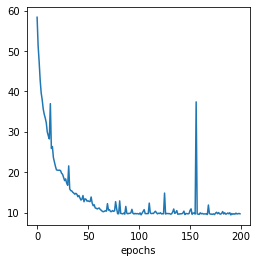

In [22]:
plt.figure()
plt.plot(np.arange(0, len(test_loss_list), 1), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.show()

In [23]:
decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

In [24]:
# Save after training
#with open('../decoders/decoder_car_Zimbabwe_63_50_loc05', 'wb') as file:
#    pickle.dump(decoder_params, file)

In [25]:
# Load 
#with open('../decoders/decoder_car_Zimbabwe_63_50_loc05', 'rb') as file:
#    decoder_params = pickle.load(file)
#    print(len(decoder_params))

#args["decoder_params"] = decoder_params

## Plot what VAE has learnt

In [26]:
N = s.shape[0]

In [27]:
decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

z_dim, hidden_dim = decoder_params[0][0].shape
    
decoder_nn = vae_decoder(hidden_dim, N)  

# check output of the decoder
for i in range(10):
    z = jnp.ones(z_dim) + i
    print(decoder_nn[1](decoder_params, z)[0:4])

[-0.48029816 -0.3304171   0.46411562  0.18793038]
[-1.1352009  -0.55758953  0.7879132   0.3499658 ]
[-1.895134   -0.72320276  1.0424943   0.45794496]
[-2.7042036  -0.86815625  1.2719903   0.53033555]
[-3.5355759 -1.0068637  1.4958906  0.5792994]
[-4.373588  -1.1468612  1.7229762  0.6127448]
[-5.211266  -1.2912453  1.9559906  0.6358019]
[-6.046133   -1.440915    2.1950428   0.65183836]
[-6.8775845  -1.5956916   2.4393935   0.66307044]
[-7.705726   -1.7547402   2.6881528   0.67092717]


In [28]:
def vae_sample(args):
    
    decoder_params = args["decoder_params"] 
    z_dim, hidden_dim = decoder_params[0][0].shape
    
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder( hidden_dim, N)  
    car_std = numpyro.deterministic("car_std", decoder_nn[1](decoder_params, z)) 

In [29]:
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
vae_predictive = Predictive(vae_sample, num_samples=12)
vae_draws = vae_predictive(rng_key_predict, args)['car_std']

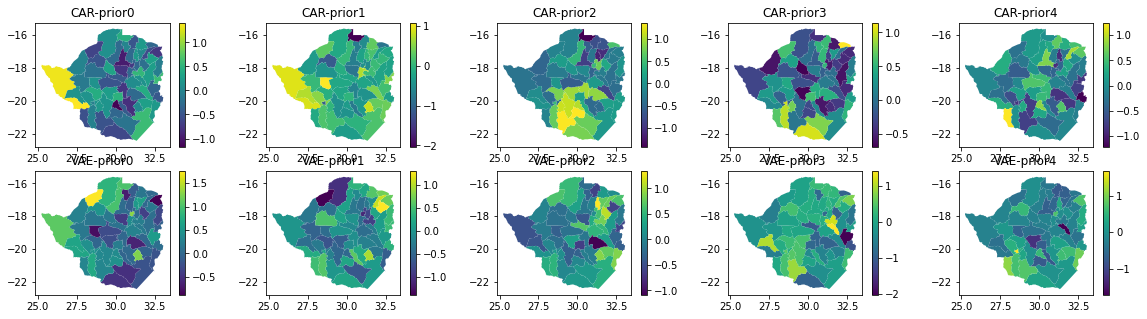

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
    nm = 'car_draw_' + str(i)
    s_plot.plot(column=nm, ax=axs[0,i], legend=True)
    axs[0,i].set_title( 'CAR-prior' + str(i))
    
for i in range(5):
    nm = 'vae_draw_' + str(i)
    s_plot[nm] = vae_draws[i,:]
    s_plot.plot(column=nm, ax=axs[1,i], legend=True)
    axs[1,i].set_title( 'VAE-prior' + str(i))

## Prevalence model - VAE

In [31]:
def prev_model_VAE(args, y=None):
    
    n_obs = args['n_obs']    
    N = len(n_obs)
    
    decoder_params = args["decoder_params"] 
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder( hidden_dim, N)  
    car_std_vae = numpyro.deterministic("vae_car_std", decoder_nn[1](decoder_params, z))

    
    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Gamma(6, 4)) 
    
    sigma = numpyro.deterministic('sigma', 1./jnp.sqrt(tau))
    vae_car = numpyro.deterministic('vae_car', sigma * car_std_vae)
    vae_car0 = numpyro.deterministic('VAE-CAR 1', vae_car[0])
    
    lp = b0 + vae_car
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
     
    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [32]:
rng_key, rng_key_predict = random.split(random.PRNGKey(6))

# inference
start = time.time()
kernel = NUTS(prev_model_VAE)
mcmc_vae = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc_vae.run(rng_key, args, y = jnp.array(s.y))
t_elapsed = time.time() - start

prev_samples = mcmc_vae.get_samples()
#mcmc.print_summary()

sample: 100%|██████████████████████████████████████████████| 3000/3000 [00:03<00:00, 907.21it/s, 31 steps of size 1.79e-01. acc. prob=0.92]


In [33]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['vae_car']['n_eff'])
print("Average ESS for all VAE-CAR effects : " + str(round(r)))


MCMC elapsed time: 4 s
Average ESS for all VAE-CAR effects : 2313


In [34]:
#mcmc.print_summary(exclude_deterministic = False)

In [35]:
#prev_samples_vae_az = az.from_numpyro(mcmc_vae)
#az.plot_trace(prev_samples_vae_az,  var_names=("VAE-CAR 1"))
#az.plot_autocorr(prev_samples_vae_az, var_names=("VAE-CAR 1"))

array([[<AxesSubplot:title={'center':'VAE-CAR 1'}>,
        <AxesSubplot:title={'center':'VAE-CAR 1'}>]], dtype=object)

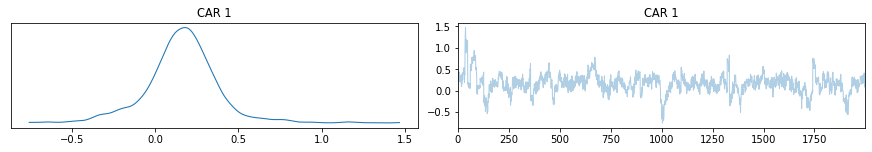

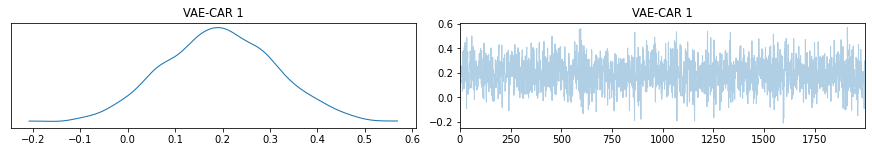

In [36]:
prev_samples_vae_az = az.from_numpyro(mcmc_vae)
prev_samples_car_az = az.from_numpyro(mcmc_car)
az.plot_trace(prev_samples_car_az,  var_names=("CAR 1"))
az.plot_trace(prev_samples_vae_az,  var_names=("VAE-CAR 1"))

In [36]:
#az.plot_trace(prev_samples_car_az,  var_names=("CAR 1"))
#az.plot_trace(prev_samples_vae_az,  var_names=("VAE-CAR 1"))

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#fig.savefig("../res/Zimbabwe_traceplots.pdf")

In [37]:
#az.plot_autocorr(prev_samples_car_az, var_names=("CAR 1"))
#az.plot_autocorr(prev_samples_vae_az, var_names=("VAE-CAR 1"))

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#fig.savefig("../res/Zimbabwe_autocorr.pdf")

In [38]:
#prev_samples_vae_az = az.from_numpyro(mcmc)
#az.plot_trace(prev_samples_vae_az,  var_names=("vae_car"))

In [39]:
#az.plot_autocorr(prev_samples_vae_az,  var_names=("vae_car"))

In [40]:
#az.plot_ess(prev_samples_vae_az, var_names=["vae_car"], kind="evolution")

Text(0.5, 1.0, 'Estimated prevalence (VAE-CAR)')

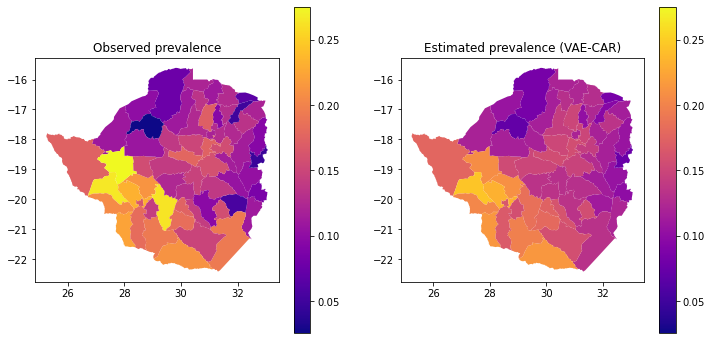

In [37]:
# posterior predictive
prev_posterior_predictive_vae = Predictive(prev_model_VAE, prev_samples)(random.PRNGKey(1), args)

theta_sams_vae_car = prev_posterior_predictive_vae['theta']
theta_mean_vae_car = theta_sams_vae_car.mean(axis=0)
bci_vae_car_25 = np.quantile(theta_sams_vae_car, 0.25, axis=0)
bci_vae_car_75 = np.quantile(theta_sams_vae_car, 0.75, axis=0)

s['theta_vae_car'] = theta_mean_vae_car

theta_observed = s['estimate']
theta_estimated = s['theta_vae_car']

_max = np.max([theta_observed, theta_estimated])
_min = np.min([theta_observed, theta_estimated])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (VAE-CAR)')

Text(0, 0.5, 'Parameter estimate')

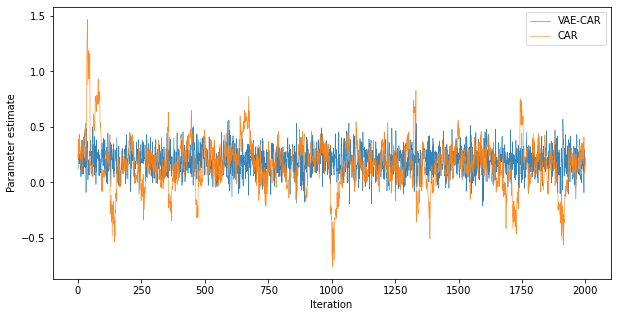

In [38]:
vaecar0_samps = prev_posterior_predictive_vae['VAE-CAR 1']
n_samps = vaecar0_samps.shape[0]
car0_samps = prev_posterior_predictive['CAR 1']
n_samps = car0_samps.shape[0]

import pandas as pd
df_plt = pd.DataFrame({'VAE-CAR':vaecar0_samps, 'CAR': car0_samps})
df_plt.head()
df_plt.plot(lw = 0.6, alpha=0.9, figsize=(10, 5))
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("Parameter estimate")
#plt.show()

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig("../res/Zimbabwe_traceplots.pdf")


/opt/anaconda3/envs/statrethinking/lib/python3.9/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/anaconda3/envs/statrethinking/lib/python3.9/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/anaconda3/envs/statrethinking/lib/python3.9/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/anaconda3/envs/statrethinking/lib/python3.9/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support wil

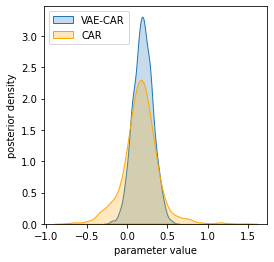

In [39]:
import seaborn as sns

#sns.kdeplot(y=vaecar0_samps,  color='#1f77b4', shade='True', Label='VAE-CAR')
#sns.kdeplot(y=car0_samps, color='orange', shade='True', Label='CAR')

sns.kdeplot(vaecar0_samps,  color='#1f77b4', shade='True', Label='VAE-CAR')
sns.kdeplot(car0_samps, color='orange', shade='True', Label='CAR')


#plt.xlim(-1, 1)
#plt.xlabel('posterior density')
#plt.ylabel('parameter value')

plt.xlabel('parameter value')
plt.ylabel('posterior density')

plt.legend(loc='upper left')

#plt.rcParams['figure.dpi'] = 100
#plt.rcParams['savefig.dpi'] = 100
#plt.savefig("../res/Zimbabwe_density.pdf")


In [40]:
#az.plot_ess(prev_samples_vae_az, var_names=["VAE-CAR 1"], kind="evolution")
#az.plot_ess(prev_samples_car_az, var_names=["CAR 1"], kind="evolution")

<AxesSubplot:title={'center':'CAR 1\n0'}>

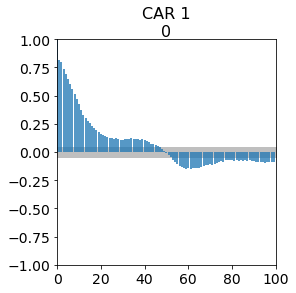

In [41]:
az.plot_autocorr(prev_samples_car_az, var_names=("CAR 1"))

<AxesSubplot:title={'center':'VAE-CAR 1\n0'}>

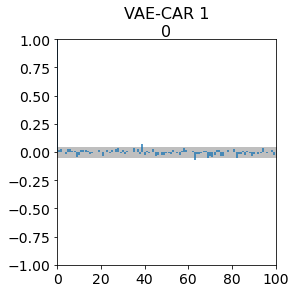

In [42]:
az.plot_autocorr(prev_samples_vae_az, var_names=("VAE-CAR 1"))

In [43]:
s.columns

Index(['area_id', 'geometry', 'y', 'n_obs', 'estimate', 'theta_car',
       'theta_vae_car'],
      dtype='object')

Text(0.5, 1.0, 'Estimated prevalence (VAE-CAR)')

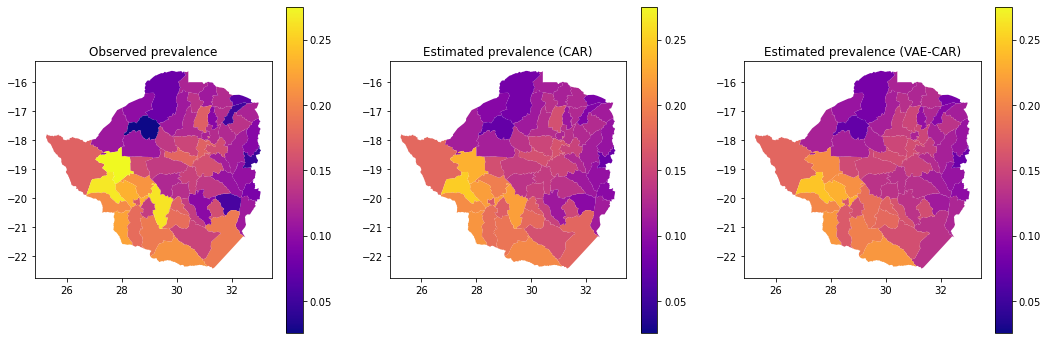

In [44]:
_max = np.max([s['estimate'], s['theta_car'], s['theta_vae_car']])
_min = np.min([s['estimate'], s['theta_car'], s['theta_vae_car']])

fig, ax = plt.subplots(1, 3, figsize=(18,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae_car", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (CAR)')
ax[2].set_title( 'Estimated prevalence (VAE-CAR)')

In [45]:
s.columns

Index(['area_id', 'geometry', 'y', 'n_obs', 'estimate', 'theta_car',
       'theta_vae_car'],
      dtype='object')

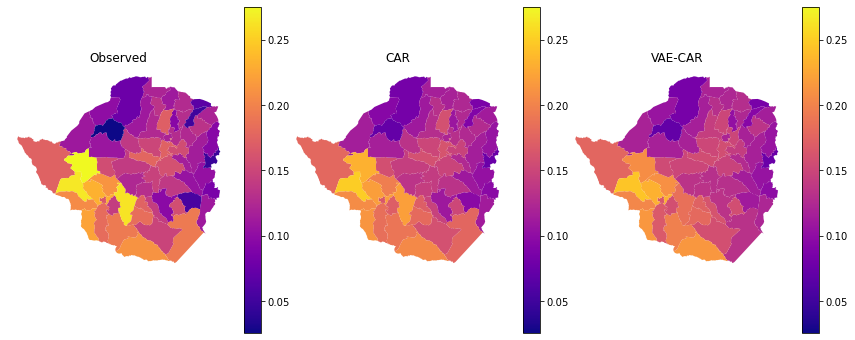

In [46]:
var = ['estimate', 'theta_car', 'theta_vae_car']
ttls = ['Observed', 'CAR', 'VAE-CAR']

_max = np.max([s['estimate'], s['theta_car'], s['theta_vae_car']])
_min = np.min([s['estimate'], s['theta_car'], s['theta_vae_car']])

fig, axs = plt.subplots(1, len(var), figsize=(15, 6))

for i in range(len(var)):
    s.plot(column=var[i], ax=axs[i], legend=True, cmap='plasma', vmin=_min, vmax =_max)
    #df.plot(column=var[i], ax=axs[i])
    axs[i].axis('off')
    axs[i].set_title(ttls[i])

fig.subplots_adjust(wspace=0, hspace=0)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#fig.savefig("../res/Zimbabwe_maps_CAR_VAECAR.pdf")

Text(0, 0.5, 'Estimated prevalence: VAE-CAR')

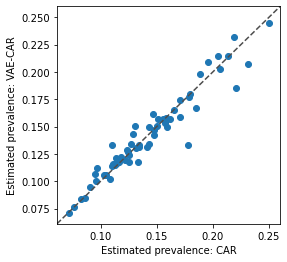

In [47]:
_max = np.max([ s['theta_car'], s['theta_vae_car']])
_min = np.min([ s['theta_car'], s['theta_vae_car']])

plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_car'], s['theta_vae_car'])
plt.ylim(_min-0.01, _max+0.01)
plt.xlim(_min-0.01, _max+0.01)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("Estimated prevalence: CAR")
plt.ylabel("Estimated prevalence: VAE-CAR")

Text(0, 0.5, 'observed theta')

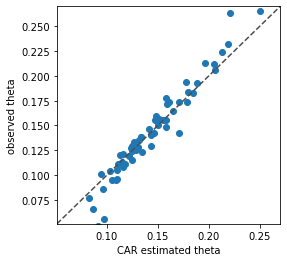

In [48]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_car'], s['estimate'])
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("CAR estimated theta")
plt.ylabel("observed theta")

Text(0, 0.5, 'observed theta')

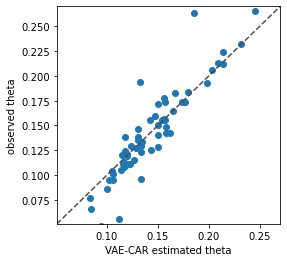

In [49]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_vae_car'], s['estimate'])
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("VAE-CAR estimated theta")
plt.ylabel("observed theta")

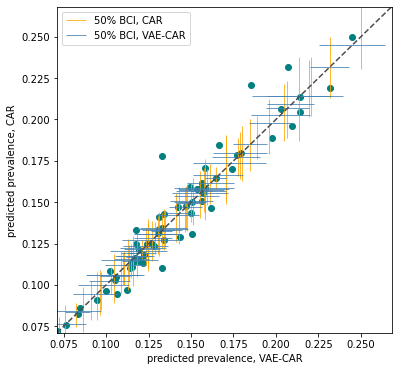

In [50]:
_max = np.max([ theta_mean_vae_car, theta_mean_car, bci_car_25, bci_car_75, bci_vae_car_25, bci_vae_car_75])
_min = np.min([ theta_mean_vae_car, theta_mean_car])

plt.rcParams["figure.figsize"] = (6,6)

plt.ylim(_min, _max)
plt.xlim(_min, _max)
plt.plot([_min, _max], [_min, _max], ls="--", c=".3")
plt.xlabel("predicted prevalence, VAE-CAR")
plt.ylabel("predicted prevalence, CAR")

plt.vlines(x=theta_mean_car, 
           ymin=bci_car_25,
           ymax=bci_car_75,
           color="orange", 
           label="50% BCI, CAR", 
           linewidth=0.8)
plt.hlines(y=theta_mean_vae_car, 
           xmin=bci_vae_car_25,
           xmax=bci_vae_car_75,
           color="steelblue", 
           label="50% BCI, VAE-CAR", 
           linewidth=0.8)

plt.scatter(theta_mean_vae_car, theta_mean_car, color="teal")
plt.legend(loc="upper left")
